In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

%matplotlib inline

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

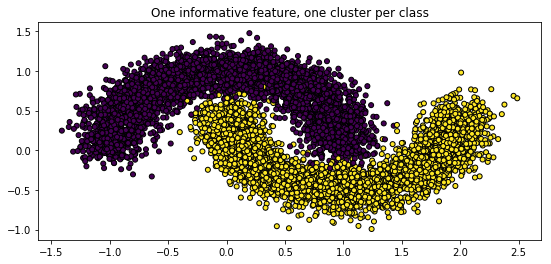

In [2]:
plt.figure(figsize=(9, 4))
plt.title("One informative feature, one cluster per class")
X, y = make_classification(n_samples=7500, n_features=2, n_classes=2,
                               n_redundant=0, n_informative=2, n_clusters_per_class=1)
X, y = make_moons(7500, noise=0.15)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

5250 2250 5250 2250


In [4]:
class Layer:
    
    def __init__(self, name=1, inputs=1, outputs=1, activation='sigmoid'):
        self._name = name
        self.W = np.random.rand(outputs, inputs) * np.sqrt(2 / (outputs + inputs))
        self.B = np.zeros((outputs, 1))
        self.A = np.zeros((self.W.shape[0], inputs))
        
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        else:
            self._activation = self._relu
    
    def __str__(self):
        return f'Layer: {self._name}'
    
    def __repr__(self):
        return f'Layer: {self._name}'
    
    def _sigmoid(self, Z, deriv=False):
        if deriv == True:
            return Z * (1 - Z)
        return 1. / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv == True:
            return 1. * (Z > 0)
        return np.maximum(0, Z)

    def forward(self, Z, active=True):
        self.A = np.dot(self.W, Z) + self.B
        if active:
            self.A = self._activation(self.A)
        return self.A
    
    def E_grad(self, E):
        return E * self._activation(self.A, deriv=True)

    
class MultiLayerPerceptron:
    
    def __init__(self, layers, X, y):
        # That is why we seed the generator - to make sure that we always get the same random numbers.
        np.random.seed(0)
        # Initialization
        self._layers = layers
        self._X = X
        self._y = np.array([y])
        self._total_samples = 1. / self._y.shape[1]
        self._total_layers = len(layers)
        self._mem_weights = {}
    
    def _mse(self, Z):
        return np.sum(Z**2) * self._total_samples
    
    def train(self, epochs=1500, lr=1e-3, batch_size=32):
        error_step = []
        total_expected_error = 0
        
        m = self._total_samples
        for ep, epoch in enumerate(range(epochs)):
            S = self._X.copy()
            
            # Forward
            Z = self.predict(S)

            # Backward
            E = Z - self._y  # error

            # Backprop
            E_prev = E
            # First Layer
            last_layer = self._layers[-1]
            delta = E_prev
            self._mem_weights[f'{last_layer}'] = (
                m * np.dot(delta, self._layers[-2].A.T), # dW 
                m * np.sum(delta, axis=1, keepdims=True) # dB
            )

            # Hidden Layers
            k = len(self._layers)-2
            for layer in reversed(self._layers[1:len(self._layers)-1]):
                E_prev = np.dot(last_layer.W.T, E_prev)
                last_layer = layer
                delta = last_layer.E_grad(E_prev)
                self._mem_weights[f'{last_layer}'] = (
                    m * np.dot(delta, self._layers[(k-1)].A.T), # dW 
                    m * np.sum(delta, axis=1, keepdims=True) # dB
                )
                k -= 1

            # Last Layer
            E_prev = np.dot(last_layer.W.T, E_prev)
            last_layer = self._layers[0]
            delta = last_layer.E_grad(E_prev)
            self._mem_weights[f'{last_layer}'] = (
                m * np.dot(delta, self._X.T), # dW
                m * np.sum(delta, axis=1, keepdims=True) # dB
            )

            # Update weights and bias
            for layer in reversed(self._layers):
                W, B = self._mem_weights[f'{layer}']
                layer.W -= lr * W
                layer.B -= lr * B
            
            # Cost
            total_error = self._mse(E)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)
        return np.array(error_step)
        
    def predict(self, Z):
        for i, layer in enumerate(self._layers):
            Z = layer.forward(Z, active=True if i < len(self._layers)-1 else False)
        return Z

Acurácia: 97.24%
Acurácia: 97.24%
Acurácia: 97.24%
Acurácia: 97.24%
Acurácia: 97.24%


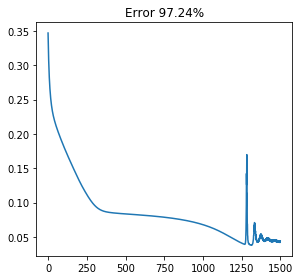

In [7]:
final_error = None
better_acc = 0

for _ in range(5):
    layers = (
        Layer(1, inputs=2, outputs=8, activation='relu'),
        Layer(2, inputs=8, outputs=6, activation='relu'), 
        Layer(3, inputs=6, outputs=4, activation='relu'), 
        Layer(4, inputs=4, outputs=4, activation='relu'), 
        Layer(5, inputs=4, outputs=1, activation='relu'), 
    )
    
    md = MultiLayerPerceptron(layers, X_train.copy().T, y_train.copy().T)
    error = md.train(lr=1e-1)
    y_pred = np.where(md.predict(X_test.copy().T) > .5, 1, 0)
    acc = np.round((np.sum(y_pred == y_test) / len(y_test)) * 100, 2)
    if acc > better_acc:
        final_error = error
        better_acc = acc
    print(f'Acurácia: {acc}%')

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

In [6]:
for _ in range(5):
    clf = MLPClassifier(
        max_iter=1500,
        solver='sgd',
        batch_size=X_train.shape[0],
        shuffle=False,
        learning_rate_init=1e-1,
        random_state=0
    )
    clf.fit(X_train, y_train)
    print(f'Acurácia: {np.round(clf.score(X_test, y_test) * 100, 2)}%')

Acurácia: 98.8%
Acurácia: 98.8%
Acurácia: 98.8%
Acurácia: 98.8%
Acurácia: 98.8%
